In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import computational_graph
from chainer import serializers

In [2]:
from utils.mnist_reader import load_mnist


In [3]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')
#X_train, y_train = load_mnist('fashion-mnist/data/fashion', kind='train')
#X_test, y_test = load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [5]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

In [6]:
X_train
y_train

array([9, 0, 0, ..., 3, 0, 5])

In [7]:
X_train[786]

array([   0.,    0.,    0.,    0.,    0.,    2.,    0.,    2.,    0.,
          0.,    0.,  177.,  168.,  170.,  166.,  166.,   42.,    0.,
          0.,    0.,    0.,    0.,    0.,    2.,    2.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,    0.,
          0.,   15.,   39.,  188.,    0.,   22.,    0.,   68.,  177.,
         77.,    0.,    0.,    0.,    4.,    4.,    2.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        106.,   64.,  221.,    0.,  150.,   75.,   66.,   31.,  126.,
        184.,  121.,  199.,   79.,   42.,    0.,    2.,    4.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         90.,  117.,  130.,  124.,   75.,  215.,  102.,   11.,   24.,
        159.,   68.,  146.,  117.,  146.,  124.,   13.,    0.,    6.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,  121.,  172.,  115.,  104.,  102.,  164.,  128.,  141.,
        230.,  184.,

In [8]:
X_train /= X_train.max()
X_test /= X_test.max()

In [9]:
X_train.shape
X_train[786]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00784314,  0.        ,  0.00784314,  0.        ,  0.        ,
        0.        ,  0.69411767,  0.65882355,  0.66666669,  0.65098041,
        0.65098041,  0.16470589,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00784314,  0.00784314,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00784314,
        0.        ,  0.        ,  0.05882353,  0.15294118,  0.73725492,
        0.        ,  0.08627451,  0.        ,  0.26666668,  0.69411767,
        0.3019608 ,  0.        ,  0.        ,  0.        ,  0.01568628,
        0.01568628,  0.00784314,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.41568628,  0.25098041,
        0.86666667,  0.        ,  0.58823532,  0.29411766,  0.25

In [10]:
y_train.shape

(60000,)

In [11]:
def draw_digit(data):
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

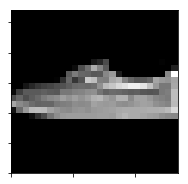

In [12]:
index = 40000
draw_digit(X_train[index])

In [13]:
y_train[index]
def change(data):
    a = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}
    return a[data]

In [14]:
change(y_train[index])

'Sneaker'

In [15]:
print(len(X_train))

60000


In [16]:
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 900)  # 第1層からの入力784､第2層への出力900
            self.l2=L.Linear(900, 1000) # 第2層からの入力600､第3層への出力1000
            self.l3=L.Linear(1000, 500) # 第3層からの入力1000､第4層への出力500
            self.l4=L.Linear(500, 10)   # 第4層からの入力500､出力層への出力10
        
    
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  # 1つめの隠れ層からの出力を計算
        h2 = F.relu(self.l2(h1)) # 2つめの隠れ層からの出力を計算
        h3 = F.relu(self.l3(h2)) # 3つめの隠れ層からの出力を計算
        return self.l4(h3)       # 出力層への入力を返す

In [17]:
model = L.Classifier(MLP())

In [18]:
gpu = -1

In [19]:
if gpu >= 0:
    xp = cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
else:
    xp = np
    

In [20]:
optimizer = chainer.optimizers.SGD()  # 今回はSGDを利用
optimizer.setup(model)                # モデルを読み込ませる

In [21]:
batch_size = 100
n_epoch = 20


In [22]:
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [23]:
train = tuple_dataset.TupleDataset(X_train, y_train)
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [24]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)

In [25]:
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [26]:
test = tuple_dataset.TupleDataset(X_test,y_test)

In [27]:
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)

In [28]:
trainer.extend(extensions.Evaluator(test_iter, model))

In [29]:
trainer.extend(extensions.LogReport())

In [30]:
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [31]:
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [32]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           1.02654     0.691733       0.674897              0.7734                    
2           0.589843    0.800733       0.551309              0.8098                    
3           0.512177    0.822783       0.523022              0.815                     
4           0.475639    0.834167       0.491025              0.8286                    
5           0.451395    0.841483       0.470736              0.8344                    
6           0.432838    0.8487         0.454669              0.8372                    
7           0.419193    0.8534         0.451254              0.8392                    
8           0.404855    0.8592         0.431827              0.8488                    
9           0.395823    0.86045        0.424217              0.8482                    
10          0.385557    0.865667       0.410109              0.8543                    
11          0.377252    0.8673    

In [34]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

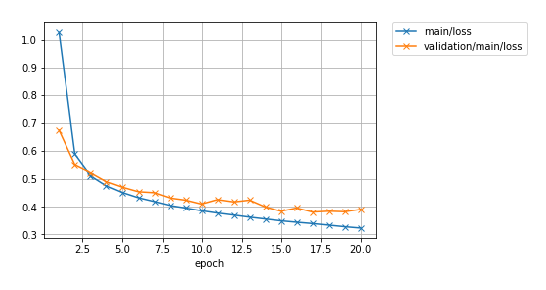

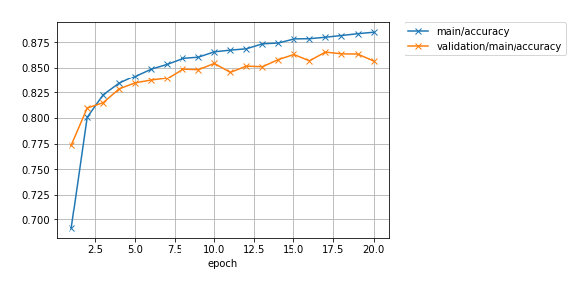

In [35]:
show_graph('result/loss.png')
show_graph('result/accuracy.png')
#少し過学習気味

In [36]:
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

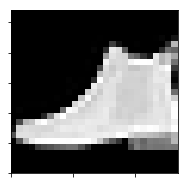

In [37]:
index = 123
draw_digit(X_test[index])

In [38]:
pred = predict(model, X_test[index])
ans  = y_test[index]

print('predict: ', pred)
print('answer : ', ans)

if pred == ans:
    print('正解です｡')
else:
    print('不正解です')


predict:  9
answer :  9
正解です｡


In [39]:
from sklearn.metrics import confusion_matrix as cm
result = predict(model, X_test)
cm(result, y_test)

array([[678,   2,   9,  10,   0,   0,  68,   0,   1,   0],
       [  0, 962,   1,  10,   1,   0,   1,   0,   1,   0],
       [  8,   0, 749,   8, 100,   0,  63,   0,   3,   0],
       [ 60,  28,  19, 906,  43,   1,  41,   0,  10,   0],
       [  2,   2,  78,  25, 703,   0,  39,   0,   2,   0],
       [  1,   0,   0,   0,   1, 932,   0,  16,   3,   5],
       [239,   5, 140,  36, 144,   0, 775,   0,  17,   1],
       [  1,   0,   0,   0,   0,  49,   0, 961,   7,  48],
       [ 11,   1,   4,   5,   8,   1,  13,   0, 956,   0],
       [  0,   0,   0,   0,   0,  17,   0,  23,   0, 946]])

In [40]:
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(xp.arange(0, 10, 1)) # x軸の目盛りを指定
    plt.yticks(xp.arange(0, 10, 1)) # y軸の目盛りを指定
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

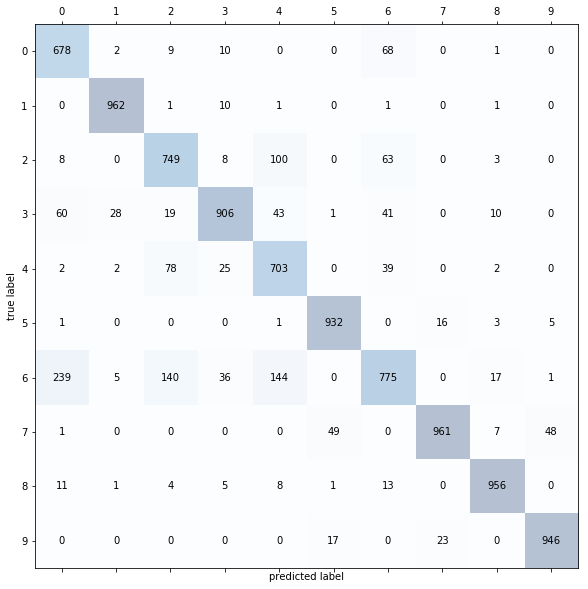

In [41]:
plot_cm(result, y_test)

In [42]:
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.857
recall: 0.857
precision: 0.868
f1_score: 0.858


In [43]:
serializers.save_npz('fashion-mnist.model', model)
print('Saved the model.')

Saved the model.


In [55]:
serializers.load_npz('fashion-mnist.model', model)
print('Loaded the model.' )

Loaded the model.


In [56]:
model